<h1 style="text-align: center;">Introduction</h1>
<br>
<br>
I worked on this project as part of a course on Big Data Analysis (2016) in graduate school. Instead of taking a look at a more mainstream topic like finance, social networking, or another practical avenue, I chose to look at eye-witness reports of UFOs. My primary motivation was curiosity, but the project was also sort of a welcomed break from my routine thesis work. For this project, reports were scraped from <a href="http://www.nuforc.org" target="_blank">nuforc.org</a> using <a href="https://github.com/Dascienz/UFO_Sightings/blob/master/ufoSpider.py" target="_blank">ufoSpider.py</a>. The dataset is relatively small, but very interesting nontheless. Some goals presented themselves as I looked through the data: <ul style="list-style-type: none;"><li>1) Find commonalities or patterns in reported UFO Sightings.</li><li>2) Develop a UFO credibility classifier.</li><li>3) And of course... Have fun!</li></ul>

Routines I used for cleaning up the scraped data can be found in <a href="https://github.com/Dascienz/UFO_Sightings/blob/master/ufoProcessing.py">ufoProcessing.py</a>. There's quite a bit brute force that was used during the scrubbing process, but the finalized dataframe was worth it in the end. Anywho, without further ado, let's take a look at this data!
<br>
<br>

In [2]:
import pandas as pd

data = pd.read_csv("~/Desktop/PythonCode/Portfolio/UFO Sightings/Data/ufoData.csv", index_col=0)
data.head()

,color,datetime,day,duration,hour,lat,lon,month,shape,summary,weekday,year,yearday
0,unspecified,1996-06-24 00:30:00,24.0,60.0,0.0,39.729432,-104.831919,6.0,changing,Referred to Marilyn Childs to call CO state di...,Monday,1996.0,176.0
1,silver,NaN,NaN,10.0,NaN,52.804300,-2.105589,NaN,cone,"((NUFORC Note: Date is unknown. PD)),hovering...",NaN,NaN,NaN
2,unspecified,NaN,NaN,NaN,NaN,-17.670916,141.078042,NaN,cross,a shape like a cross with a circle in the midd...,NaN,NaN,NaN
3,unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cylinder,I video taped a UFO off the tv (cnn/headline n...,NaN,NaN,NaN
4,unspecified,2016-10-15 20:00:00,15.0,2.0,20.0,39.624609,-105.084204,10.0,cross,"Lakewood UFO,1 bright light at the very top,th...",Saturday,2016.0,289.0


In [3]:
data['summary'][10950]

'circular object in sky with red and green lights pulsed,I was sitting on the back porch and looked up to the sky and saw a circular object with two red lights side by side and two green lights side by side creating a square inside the circle. It was pulsing and rotated half turn in place to flip red and green lights.  It then flipped back. I ran in the house to get my phone to video and recorded it.  It hovered across the sky above me. Shot forward.  Stopped.  Glided back a bit.  Then went to the right. Then sped off fast. No sound. Then disappeared.'

In [4]:
len(data['summary'])

104244

So there aren't too many reports here and as far as 'big data' is concerned, this is a tiny set with only 104,244 rows. I've read a good number of these summaries out of pure curiosity, and a lot of them are very interesting and peculiar. I did a lot of wrangling to structure these reports into a nice DataFrame format, but a lot of information is missing in some of the columns as a result of incomplete accounts from the witnesses. Some features, like color for example, were extracted from the text descriptions. My hacky methods can all be viewed in <a href="https://github.com/Dascienz/UFO_Sightings/blob/master/ufoProcessing.py">ufoProcessing.py</a>. To start, I first mapped spatial distributions of the sightings using Basemap and geographic coordinates obtained through geopy.

<h1 style="text-align: center;">Sightings Geodata</h1>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.basemap import Basemap

def worldMap(data):
    """Total world sightings map."""
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_axes([0.05, 0.05, 0.9, 0.9])

    m = Basemap(projection='kav7',lon_0 = 0,resolution = None)
    m.drawmapboundary(fill_color='0.3')
    m.shadedrelief()

    # Draw parallels and meridians.
    m.drawparallels(np.arange(-90.,99.,30.))
    m.drawmeridians(np.arange(-180.,180.,60.))

    # Calculate the point density
    lonx = data['lon'][np.isnan(data['lon']) == False].values
    laty = data['lat'][np.isnan(data['lat']) == False].values
    xy = np.vstack([lonx,laty])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = lonx[idx], laty[idx], z[idx]

    xmap, ymap = m(x,y)
    sc = m.scatter(xmap, ymap, c=z, s=20, edgecolor='', cmap=plt.cm.plasma)
    ax.set_title('World UFO Sightings')
    m.colorbar(sc, location='bottom', pad='3%')
    plt.show()

def naMap(data):
    """North America sightings map."""
    fig = plt.figure()
    m = Basemap(projection='lcc',
                llcrnrlon=-119, 
                llcrnrlat=22, 
                urcrnrlon=-64,
                urcrnrlat=49, 
                lat_1=33, 
                lat_2=45,
                lon_0=-95,
                area_thresh=10000)

    m.drawmapboundary(linewidth= 1.5)
    m.drawstates()
    m.drawcountries()
    m.shadedrelief()

    # Calculate the point density
    lonx = data['lon'][np.isnan(data['lon']) == False].values
    laty = data['lat'][np.isnan(data['lat']) == False].values
    xy = np.vstack([lonx,laty])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = lonx[idx], laty[idx], z[idx]
    xmap, ymap = m(x, y)
    sc = m.scatter(xmap, ymap, c=z, s=30, edgecolor='', cmap=plt.cm.plasma)
    plt.title('United States UFO Sightings')
    m.colorbar(sc, location='right', pad='5%')
    plt.tight_layout()
    plt.show()

"""
Is there a correlation with airport, heliport, and seaplane base location?
Airport data obtained and sliced from: https://www.faa.gov/airports/airport_safety/airportdata_5010/
"""
airports = pd.read_csv('~/Desktop/PythonCode/Portfolio/UFO Sightings/Data/airportData.csv')
airports = airports.dropna().reset_index(drop=True)

# Have to convert latitude and longitude to a standard scale
# for map plotting.
def convert(tude):
    multiplier = 1 if tude[-1] in ['N', 'E'] else -1
    return multiplier*sum(float(x)/60**n for n, x in enumerate(tude[:-1].split('-')))

airports['Lon'] = [convert(l) for l in airports['ARPLongitude']]
airports['Lat'] = [convert(l) for l in airports['ARPLatitude']]
airports['ActivationDate'] = pd.to_datetime(airports['ActiviationDate'].astype('str'), errors = 'coerce')

# Plotting airports for the USA
def airportMap(airports):
    fig = plt.figure()
    m = Basemap(projection='lcc',
                llcrnrlon=-119, 
                llcrnrlat=22, 
                urcrnrlon=-64,
                urcrnrlat=49, 
                lat_1=33, 
                lat_2=45,
                lon_0=-95,
                area_thresh=10000)

    m.drawmapboundary(linewidth= 1.5)
    m.drawstates()
    m.drawcountries()
    m.shadedrelief()

    # Calculate the point density
    lonx = airports['Lon'][(airports['ActivationDate'] >= pd.Timestamp('1950-01-01'))].values
    laty = airports['Lat'][(airports['ActivationDate'] >= pd.Timestamp('1950-01-01'))].values
    xy = np.vstack([lonx,laty])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = lonx[idx], laty[idx], z[idx]
    xmap, ymap = m(x, y)

    sc = m.scatter(xmap, ymap, c=z, s=30, edgecolor='', cmap=plt.cm.plasma)
    m.colorbar(sc, location='right', pad='5%')
    plt.title('United States Airports, Heliports, and Seaplane Bases')
    plt.tight_layout()
    plt.show()

"""
Is there any visible correlation between Sightings and Military Base locations?
Military bases obtained from 'https://www.google.com/maps/d/viewer?mid=1XFBnIuaJ-71hcaDJvdmBmeXNhYM&hl=en&ll=47.323248104393414%2C-114.05083400000001&z=3'
"""
military = pd.read_csv('~/Desktop/PythonCode/Portfolio/UFO Sightings/Data/militaryData.csv')
military = military.dropna().reset_index(drop=True)

# Plotting Military Bases in the USA
def militaryMap(military):
    fig = plt.figure()
    m = Basemap(projection='lcc',
                llcrnrlon=-119, 
                llcrnrlat=22, 
                urcrnrlon=-64,
                urcrnrlat=49, 
                lat_1=33, 
                lat_2=45,
                lon_0=-95,
                area_thresh=10000)

    m.drawmapboundary(linewidth= 1.5)
    m.drawstates()
    m.drawcountries()
    m.shadedrelief()

    # Calculate the point density
    lonx = military['longitude'].values
    laty = military['latitude'].values
    xy = np.vstack([lonx,laty])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = lonx[idx], laty[idx], z[idx]
    xmap, ymap = m(x, y)
    
    sc = m.scatter(xmap, ymap, c=z, s=60, edgecolor='black', cmap=plt.cm.plasma)
    m.colorbar(sc, location='right', pad='5%')
    plt.title('United States Military Bases')
    plt.tight_layout()
    plt.show()

<img src="/img/World_UFO_Heatmap_300dpi.png"/>
<img src="/img/America_UFO_Heatmap_300dpi.png"/>
<img src="/img/airports.png"/>
<img src="/img/military.png"/>

So from these plots we can see that most sightings have been reported from the United States, which makes sense since NUFORC is US-based. There are a number of sightings reported from outside the United States though, but the majority are indeed US-based sightings. Taking a closer look at the US, we see that sightings are most concentrated around the Pennsylvania region and souther California. To try and understand this, I also took a look at location data for airports, heliports, and seaplane bases as well as US military bases. Lo and behold, there appears to be a good, visible spatial correlation between UFO sightings hotspots and densely concentrated military bases and airports. Let's quantify the geospatial correlations to see which locations are more significant, military bases or airports?

In [5]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2):
    """
    Modified version of: http://stackoverflow.com/a/29546836/2901002,
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)
    """
    to_radians = True
    earth_radius = 6371 #km
    
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    dlat, dlon = (lat2-lat1), (lon2-lon1)
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    distance = 2*earth_radius*np.arcsin(np.sqrt(a))
    
    return distance

In [16]:
ufo_coordinates = data[['lat','lon']].copy().dropna().reset_index(drop=True) #ufo points

airport_coordinates = airports[['Lat','Lon']].copy() #airport points
airport_coordinates = airport_coordinates.rename(columns = {'Lat':'lat','Lon':'lon'})

military_coordinates = military[['latitude','longitude']].copy() #military points
military_coordinates = military_coordinates.rename(columns = {'latitude':'lat','longitude':'lon'})

Now, we don't just want to calculate every single haversine distance and find the distribution by brute force, that would take a very very very long time, and we'd have N sightings * M airport combinations to go through, which is over one billion. Instead, we can calculate the central point of sightings latitude and longitude locations and then calculate the haversine distances between the central points and airport/military base locations.

In [101]:
def point(lat, lon):
    R = 6371 #km
    x = R*np.cos(lat)*np.cos(lon)
    y = R*np.cos(lat)*np.sin(lon)
    z = R*np.sin(lat)   
    return x, y, z

def nearby_points(a,b):
    """Given a(x,y,z) and b(x,y,z), count how many points in a are close to b."""
    cutoff = 50 #50km radius
    counts = []
    for i in range(len(b)):
        print(i, flush=True)
        count = 0
        bx, by, bz = point(b.lat[i], b.lon[i])
        for j in range(len(a)):
            ax, ay, az = point(a.lat[j], a.lon[j])
            d = np.sqrt((ax-bx)**2+(ay-by)**2+(az-bz)**2)
            if d <= cutoff:
                count += 1
        counts.append(count)
    return counts

In [104]:
print(len(ufo_coordinates))
print(len(military_coordinates))
print(len(airport_coordinates))

97281
601
18512


In [75]:
from scipy.stats import norm

def point(lat, lon):
    R = 6371 #km
    x = R*np.cos(lat)*np.cos(lon)
    y = R*np.cos(lat)*np.sin(lon)
    z = R*np.sin(lat)   
    return x, y, z

def nearby_points(a,b):
    """Given a(x,y,z) and b(x,y,z), count how many points in a are close to b."""
    cutoff = 50 #50km radius
    counts, count = [], 0
    for i in range(len(b)):
        bx, by, bz = point(b.lat[i], b.lon[i])
        for j in range(len(a)):
            ax, ay, az = point(a.lat[j], a.lon[j])
            d = np.sqrt((ax-bx)**2+(ay-by)**2+(az-bz)**2)
            if d <= cutoff:
                count += 1
        counts.append(count)
    return counts
            

def center_geolocation(lats,lons):
    """
    Provide a relatively accurate center lat, lon returned as a list pair, given
    a list of list pairs.
    ex: in: geolocations = ((lat1,lon1), (lat2,lon2),)
        out: (center_lat, center_lon)
    """
    x = 0
    y = 0
    z = 0
    N = len(lats)
    
    for lat, lon in zip(lats,lons):
        x += np.cos(lat)*np.cos(lon)
        y += np.cos(lat)*np.sin(lon)
        z += np.sin(lat)

    x = (x/N)
    y = (y/N)
    z = (z/N)

    c_lat = np.arctan2(z, np.sqrt(x**2 + y**2)) #convert back to latitude
    c_lon = np.arctan2(y, x) #convert back to longitude
    
    return c_lat, c_lon

def distribution(df1,df2):
    c_lat, c_lon = center_geolocation(df1.lat, df1.lon)
    distances = []
    N = len(df2)
    for i in range(N):
        d = haversine(c_lat, c_lon, df2.lat[i], df2.lon[i])
        distances.append(d)
    
    mu = np.mean(distances)
    std = np.std(distances)
    xp = np.linspace(0, np.max(distances), 1000)
    p_dist = norm.pdf(xp, mu, std)
    return distances, p_dist

In [76]:
_, p_airports = distribution(ufo_coordinates, airport_coordinates)
_, p_military = distribution(ufo_coordinates, military_coordinates)

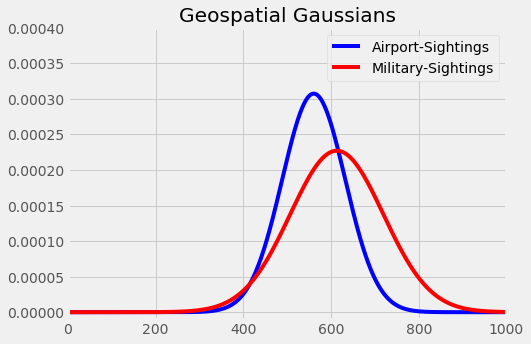

In [95]:
plt.figure(figsize=(7,5))
plt.title("Geospatial Gaussians")
plt.plot(p_airports, 'b-')
plt.plot(p_military, 'r-')
plt.legend(('Airport-Sightings','Military-Sightings'))
plt.xlim([0,1000])
plt.ylim([-0.00001,0.00040])
plt.show()

#This is very vague, let's try and count how many sightings occurr within a given radius 
#for each military base and airport using np.isclose() if True then += 1?

<h1 style="text-align: center;">Plotting</h1>

After mapping spatial distributions, I started trying to visualize sightings trends with respect to shape categorical data and time (day, year, etc.).

In [ ]:
import nltk
import itertools
import numpy as np
import matplotlib.pyplot as plt

# SHAPE DATA
def shapePlot():
    """Sightings distribution by UFO shape."""
    shape_counts = data['shape'].value_counts()
    shape_counts.plot(kind = "barh", colormap = "ocean")
    font = {'fontsize':'larger'}
    percent_font = {'fontsize':'smaller'}
    plt.title('Sightings by Shape', **font)
    plt.xlabel('Sightings')
    plt.xlim([0,36000])
    
    #Percentages by UFO Shape
    shape_percent = [s*(100.0/shape_counts.sum()) for s in shape_counts]
    X = shape_counts.values
    Y = [i for i in range(len(shape_percent))]
    for i in range(len(shape_percent)):
        x = X[i]+500
        y = Y[i]-0.2
        plt.text(x,y,'%.2f' % shape_percent[i] + '%', **percent_font)
    plt.tight_layout()
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Shape_300dpi.png" style="max-width: 800px;"/>

These shape categories are far from balanced, with light representing about 30% of all the data. There are indeed some interesting shapes listed like chevron and egg, but for now let's continue taking a look at the rest of the data.

In [ ]:
def durationPlots():
    """Durations distributions by UFO shape."""
    shapes = data['shape'].value_counts().index.tolist()
    means = ['%.1f' % data['duration'][data['shape'] == shape].mean() for shape in shapes]
    means = [float(x) for x in means]
    tuples = [*zip(shapes,means)]
    tuples.sort(key = lambda x: x[1], reverse=True)
    shapes, means = zip(*tuples)
    plt.figure()
    plt.title('Average Duration by Shape')
    plt.xlabel('Duration (minutes)')
    idy = np.arange(len(shapes))
    plt.barh(idy,means,alpha=0.5,color='red')
    plt.yticks(idy,shapes)
    plt.savefig('Sightings_by_Duration_300dpi.png', format = 'png', dpi = 300)
    plt.show()

    data_to_plot = []
    for shape in shapes:
        data_to_plot.append(data['duration'][data['shape']==shape].values)
        for array in data_to_plot:
            for i in range(len(array)):
                if np.isnan(array[i]) == True:
                    array[i] = np.nanmean(array)
                    
    plt.figure()
    plt.title('Durations Box Plots')
    plt.boxplot(data_to_plot, showfliers=False)
    plt.ylim([0,125])
    idx = np.arange(1,len(shapes)+1)
    plt.xticks(idx,shapes,rotation=90)
    plt.ylabel('Duration (minutes)')
    plt.tight_layout()
    plt.savefig('Sightings_by_Duration_Boxplot_300dpi.png', format = 'png', dpi = 300)
    plt.show()

In [ ]:
data['duration'].mean()

The average duration of a sighting roughly 30 minutes, but this seems to be thrown off by outliers with high durations. In particular, the 'other' category has a massive average duration. This category is for shapes that either weren't provided OR are not exact matches to the categories represented in nuforc's database.

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Duration_300dpi.png" style="max-width: 800px;"/>

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Duration_Boxplot_300dpi.png" style="max-width: 800px;"/>

In [ ]:
from scipy.stats import ttest_ind

def tTest(group_1, group_2):
    x = data['duration'][data['shape']==group_1]
    y = data['duration'][data['shape']==group_2]
    return ttest_ind(x.dropna().values, y.dropna().values)

for shape in data['shape'].value_counts().index.tolist():
    if shape != 'other':
        print("Compared with " + str(shape) + ": Statistic =", abs(tTest(str(shape),'other')[0]))

As far as durations data is concerned, iterated t-tests help to verify that these unspecified, or 'other', shape categories are at least statistically different from most other categories, but there is significant similarity with the 'cone' and 'cross' categories.

In [ ]:
# DISTRIBUTION BY HOUR (WITH COLOR MAPPING SCALED BY HEIGHT)
def hourPlot():
    """Sightings distribution by hour of the day."""
    total = data['hour'][(data['hour'] >= 0) & (data['hour'] <= 24)]

    cmap = plt.cm.get_cmap('autumn')
    Y,X = np.histogram(total,24,normed=1.0)
    y_span = Y.max()-Y.min()
    colors = [cmap(((y-Y.min())/y_span)) for y in Y]
    y_max = total.value_counts().sum()

    font = {'fontsize':'larger'}
    b = np.arange(0,24,1)
    plt.bar(b,Y*y_max,width=b[1]-b[0],color=colors,align='center')
    plt.xticks(b)
    plt.xlim([-0.5,23.5])
    plt.xlabel('24-hour Time')
    plt.ylabel('Sightings')
    plt.title('Sightings by Hour', **font)
    plt.tight_layout()
    plt.savefig('Sightings_by_Hour_300dpi.png', format='png',dpi=300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Hour_300dpi.png" style="max-width: 800px;"/>

Now we're getting into some more interesting territory here. UFO Sightings are lowest during traditional sleeping and working hours, which is to be expected. Sightings are highest between 6:00 P.M. and 1:00 A.M. This is a time when the sun is either setting or has already set and objects in the sky are relatively easier to track in the absence of light pollution. However, this is also a time period for recreational activities such as drinking.

In [ ]:
# DISTRIBUTION BY WEEKDAY (WITH COLOR MAPPING SCALED BY HEIGHT)
def weekdayPlot():
    """Sightings distribution by weekday."""
    total = pd.DataFrame({'weekday': data['weekday']})
    weekdays = {'Monday':1,'Tuesday':2,'Wednesday':3,
                'Thursday':4,'Friday':5,'Saturday':6,
                'Sunday':7}
    total['weekday'].replace(weekdays, inplace=True)
    total = total['weekday'][(total['weekday'] >= 1) & (total['weekday'] <= 7)]

    cmap = plt.cm.get_cmap('spring')
    Y,X = np.histogram(total,7,normed=1.0)
    y_span = Y.max()-Y.min()
    colors = [cmap(((y-Y.min())/y_span)) for y in Y]
    y_max = total.value_counts().sum()

    font = {'fontsize':'larger'}
    plt.bar(sorted(list(weekdays.values())),Y*y_max,width=1.0,
            color=colors,align='center',label=list(weekdays.keys()))
    plt.xticks(list(weekdays.values()),list(weekdays.keys()),ha='right',rotation='45')
    plt.xlim([-.5,7.5])
    plt.xlabel('Weekday')
    plt.ylabel('Sightings')
    plt.title('Sightings by Week', **font)
    plt.tight_layout()
    plt.savefig('Sightings_by_Day_300dpi.png', format='png',dpi=300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Day_300dpi.png" style="max-width: 800px;"/>

When looking at sightings by weekday, there's a visible increase in sightings as the week progresses towards the weekend, with a spike occurring on Saturday and dipping sharply from Sunday to Monday. This struck me as odd, but when combined with the hourly data trends, the data suggests that sightings could be correlated with time periods for recreational activities. Here's an <a href="https://www.economist.com/news/united-states/21605918-everything-you-need-know-about-ufos-0" target="_blank">article</a> I found which looks into the NUFORC data that helps support these observations.

In [ ]:
def monthPlot():
    """Sightings distribution by month."""
    total = data['month'][(data['month'] >= 1) & (data['month'] <= 12)]

    months = {'Jan':1,'Feb':2,'Mar':3,
              'Apr':4,'May':5,'Jun':6,
              'Jul':7,'Aug':8,'Sep':9,
              'Oct':10,'Nov':11,'Dec':12}

    cmap = plt.cm.get_cmap('summer')
    Y,X = np.histogram(total,12,normed=1.0)
    y_span = Y.max()-Y.min()
    colors = [cmap(((y-Y.min())/y_span)) for y in Y]
    y_max = total.value_counts().sum()
          
    font = {'fontsize':'larger'}
    plt.bar(list(months.values()),Y*y_max,width=1.0,
            color=colors,align='center',label=list(months.keys()))
    plt.xticks(list(months.values()),list(months.keys()),ha='right',rotation='45')
    plt.xlim([0.5,12.5])
    plt.xlabel('Month')
    plt.ylabel('Sightings')
    plt.title('Sightings by Month', **font)
    plt.tight_layout()
    plt.savefig('Sightings_by_Month_300dpi.png', format='png',dpi=300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Month_300dpi.png" style="max-width: 800px;"/>

Looking at the sightings distribution by month, we see notable spikes during January and July. Overall, sightings appear to be high in the summer, autumn, and winter seasons, but strangely enough they dip in the spring time. I personally spend a lot of time indoors during the spring season as a result of tree pollen allergies, and emerge from reclusion when the summer comes around in June, but that may not be what's happening here. This could be a correlation with seasonal trends of US flights, but I've not looked into it.

In [ ]:
# DISTRIBUTION BY YEAR
def yearPlot():
    """Sightings distribution by year."""
    total = data['year'][(data['year'] >= 1965) & (data['year'] <= 2016)]

    cmap = plt.cm.get_cmap('winter')
    Y,X = np.histogram(total,len(total.value_counts()),normed=1.0)
    y_span = Y.max()-Y.min()
    colors = [cmap(((y-Y.min())/y_span)) for y in Y]
    y_max = total.value_counts().sum()

    font = {'fontsize':'larger'}
    plt.bar(X[:-1],Y*y_max,width=X[1]-X[0],
            color=colors,align='center')
    plt.xticks(np.arange(X.min(),X.max()+1,5),ha='right',rotation='45')
    plt.xlim([1964.5,2016.5])
    plt.axvline(x=1997,color='red',linestyle='dashed')
    plt.text(1998,7000,'Google', rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Sightings')
    plt.title('Sightings by Year', **font)
    plt.axis('tight')
    plt.tight_layout()
    plt.savefig('Sightings_by_Year_300dpi.png', format='png',dpi=300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_Year_300dpi.png" style="max-width: 800px;"/>

For reference, Google's domain was officially purchased in 1997, and although NUFORC was around before then, they didn't have the accessibility or exposure they have today without search index giants like Google or the modern internet as a collective network of shared information. Thus, the rise in reports here, from my understanding, is a result of people having an accessible place to report their sightings rather than a true increase in sightings over recent years.

In [ ]:
# DISTRIBUTION BY DAY OF THE YEAR
def yeardayPlot():
    """Sightings distribution by day of the year."""
    font = {'fontsize':'larger'}
    data['yearday'].hist(bins=np.arange(0,365,3), align='left',alpha=0.75)
    plt.ylabel('Sightings')
    plt.xlabel('Day of Year')
    plt.xlim([0,365])
    plt.text(4,2000,'New Years',rotation=45,color='green')
    plt.text(188,2000,'July 4th',rotation=45,color='green')
    plt.xticks(rotation='45')
    plt.title('Sightings by Day of Year', **font)
    plt.axis('tight')
    plt.grid(False)
    plt.tight_layout()
    plt.savefig('Sightings_by_DayOfYear.png', format = 'png', dpi = 300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Sightings_by_DayOfYear.png" style="max-width: 800px;"/>

Here's a look at the sightings distribution by day of the year. The most notable spikes are around New Years and July 4th which, of course, are holidays known for their fireworks displays. I'm confident enough to say that these spikes in sightings are people mistaking fireworks for UFOs. 

In [ ]:
def colorCloud():
    """Generate wordcloud from color categories."""
    plt.figure(figsize=(8,6))
    colors = data['color'].value_counts().index.tolist()        
    frequencies = data['color'].value_counts().values.tolist() 
    color_dict = dict([*zip(colors, frequencies)][1:])
    cloud = wordcloud.WordCloud(background_color='white',
                                random_state=58,
                                width=1600,height=800)
    cloud.generate_from_frequencies(color_dict)
    plt.axis('off')
    plt.imshow(cloud.recolor(colormap=plt.cm.hsv))
    plt.savefig('Colors_Word_Cloud.png',format='png',dpi=300)
    plt.show()

<img src="/files/Desktop/PythonCode/Portfolio/UFO Sightings/Plots/Colors_Word_Cloud.png" style="max-width: 800px;"/>

Here's just a pretty word cloud showing most common colors. The prevalence of the color is represented by the size of its word in the cloud, with white being the most common color and orange and red following after it in that order. Red, white, and orange are common fireworks colors, so this adds to my concern that the dataset is polluted with fireworks sightings rather than actual UFOs. Let's take a look at major correlations within the data.

<h1 style="text-align:center;">Correlations</h1>

In [ ]:
# Dictionary for changing month categories into number tags and vise versa.
months = {'Jan':1,'Feb':2,'Mar':3,
          'Apr':4,'May':5,'Jun':6,
          'Jul':7,'Aug':8,'Sep':9,
          'Oct':10,'Nov':11,'Dec':12}
inv_months = {v:k for k,v in months.items()}
data['month'] = data['month'].replace(inv_months)

# Correlation Matrix Function
duration = data['duration']
lat = data['lat']
lon = data['lon']
shape = pd.get_dummies(data['shape'])
color = pd.get_dummies(data['color'])
weekday = pd.get_dummies(data['weekday'])
month = pd.get_dummies(data['month'])
hour = pd.get_dummies(data['hour'])
year = pd.get_dummies(data['year'])
yearday = pd.get_dummies(data['yearday'])
x = pd.concat([duration,lat,lon,shape,color,weekday,month,hour,year,yearday],axis=1)

def get_redundant_pairs(x):
    """Get diagonal and lower triangular pairs of the correlation matrix."""
    pairs_to_drop = set()
    cols = x.columns
    for i in range(0, x.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(x, n=15):
    au_corr = x.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(x)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

import warnings
warnings.filterwarnings('ignore')
get_top_abs_correlations(x, n=15)

I borrowed the above methods from <a href="https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
">StackOverflow</a>. These functions sort out the top correlations from the dataset, which in all honesty are a bit alarming for believers and UFO enthusiasts! I was able to pinpoint nearly all of these top correlations to US holidays!

<ul>
<li>Jan 1.0 - New Year's Day</li>
<li>Jul 185.0 and 186.0 - Independence Day (US)</li>
<li>Jun 166.0 - Flag Day (US)</li>
<li>Dec 365.0 - New Year's Eve</li>
<li>Aug 227.0 - National Airborne Day (US)</li>
<li>Nov 311.0 - (???)</li>
<li>May 135.0 - Peace Officers Memorial Day (US) and  Armed Forces Day (US)</li>
<li>Feb 46.0 - Valentine's Day</li>
<li>Jul 196.0 - (???)</li>
</ul>

Typical celebrations for these dates are fireworks and air shows, two activities which could understandably be mistaken for UFOs. However, there are two highly correlated days of the year which I cannot account for and if anyone figures these two out please let me know!

<h1 style="text-align:center;">Modeling</h1>

After taking a look at the UFO trends, let's take a step back and figure out what we'd like to be able to predict. For starters, there's no way of telling whether a sighting is a legitimate UFO or not, but we can use mass sightings as a metric for how <i>credible</i> a sighting is. This means that, if a sighting (same shape, location, and date) has been reported by multiple people then it is far more credible than one that has been reported by a single person. That isn't saying that single witness sightings aren't legitimate, but they certainly aren't as credible as sightings with multiple witnesses.

In [ ]:
import datetime

data = data.dropna()
data = data.reset_index(drop=True)
data = data[['shape','lat','lon','datetime','summary']]
data['datetime'] = data['datetime'].apply(lambda x: pd.Timestamp(x).date())
data = data[(data['datetime'] <= datetime.date(2017, 1, 1))]
    
cols = ['shape', 'lat', 'lon', 'datetime']
data['reports'] = data.groupby(cols).transform('count')
data['credibility'] = np.where(data['reports']>=2, 'High', 'Low')

What I've done now is grouped the data by shape, location, and datetime data in order to count sightings with more than one report. Two new columns have been added as a result. The first is data['reports'], which lists the number of sightings for a specific UFO. The second is data['credibility'] which performs a binary classifications of reports as either High or Low based on whether a specific sighting has multiple reports versus a single report.

In [ ]:
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer

#Define features (summaries) and labels (credibilities)
summaries = data['summary']
credibilities = data['credibility']

#Vectorize features, aka text summaries.
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=5)
vectors = vectorizer.fit_transform(summaries)

f_train, f_test, l_train, l_test = train_test_split(vectors, credibilities, test_size = 0.3)
svm = LinearSVC(C=0.7, class_weight='balanced')
clf = CalibratedClassifierCV(svm)
clf.fit(f_train, l_train)

I first vectorize summaries and use a Support Vector Classifier (LinearSVC was preferred over SVC(kernel='linear') due to speed differences on my laptop.) to create a binary classification model for predicting whether a UFO sighting has a high or low credibility rating based solely off of the description provided by the witness. After vectorizing the summary text, the dataset is split into a training and testing set so we can fit the model. I've chosen to use CalibratedClassifierCV() so that I can output probabilities from LinearSVC() since, for some reason, the probability parameter is not available for this function the way it is for SVC(). 

In [ ]:
"""Training Data Predictions."""
pred_train = clf.predict(f_train)
print(classification_report(l_train, pred_train))

The model does a great job making predictions on the training set, so let's try it out on the testing set.

In [ ]:
"""Testing Data Predictions."""
pred_test = clf.predict(f_test)
print(classification_report(l_test, pred_test))

It's unfortunate that the recall score for High credibility ratings took such an enormous hit on the test set, however, the model should do what it's designed to do, which is calculate the probability of a specific sighting description being of high credibility or not. Again, nothing to do with proving legitimacy, just estimating credibility. Let's just take a look at some specific cases to see how it can/should be used!

In [ ]:
"""Using the model: Percent chance credibilities."""
fake = ["I saw a white flying saucer heading southeast while I was out with my dog.\
         It hovered for a bit before disappearing. I haven't told anyone else about it."] # I wrote this, haha...

real = ["My wife and I were walking our dogs on the south side of South Mountain\
        in the mountain park when we saw the ufo come over the mountain at low\
        altitude (500'appx) headed southbound.  It was s i l e n t and had 5 white\
        globes along the leading edge of a black triangle shaped object which blacked\
        out the stars and was about a mile wide."] # description from a sighting with multiple reports... 

def credibility(summary):
    """String needs to be in a list, e.g. [Description]"""
    s = vectorizer.transform(summary)
    y_proba = clf.predict_proba(s)
    prob = y_proba[0][0]*100
    if prob > 30.0: #50% too large since even mass sightings will be around 55-60%
        return print("High credibility: " + "%.2f" % (y_proba[0][0]*100) + "%")
    else:
        return print("Low credibility: " + "%.2f" % (y_proba[0][0]*100) + "%")

The above method can be used to help make decisions on whether a particular sighting is significant or not, but of course this is just a trained guess and should not be taken as the absolute truth as to whether or not the witness observed a legitimate UFO.

In [ ]:
credibility(fake) #credibility percentage of a fake sighting
credibility(real) #credibility percentage of a real, mass sighting

We now have a basic model for assessing the credibility of UFO witness descriptions. Given limited interest in the project, I won't be working on improving the model, but techniques such as further feature extraction and regularization could certainly help improve its accuracy and recall scores. Furthermore, since there aren't many sightings with multiple witnesses, the labels are very imbalanced and the model is in sore need of more mass sightings to train on. With that said, let's look into mass sightings in more detail.

<h1 style="text-align:center;">Deeper Look at Mass Sightings</h1>

<h1 style="text-align:center;">Conclusions</h1>

<ul>
<li>Most sightings are of 'light' shaped objects.</li>
<li>Most sightings in the NUFORC database originate from the northeastern United States.</li>
<li>Most sightings occur between 6:00 P.M. and 1:00 A.M.</li>
<li>Most sightings occur on Saturdays during the summer season.</li>
<li>Sightings are strongly correlated with US holidays exhibiting fireworks and airshow displays.</li>
<li>The credibility of a sighting can be estimated by a model trained on descriptions given for sightings with multiple reports, i.e. mass sightings.</li>
</ul>